In [1]:
import tensorflow as tf
import numpy as np

# Layers
from tensorflow.keras.layers import Dropout #
from tensorflow.keras.layers import Reshape #
from tensorflow.keras.layers import Lambda #
from tensorflow.keras.layers import Input #
from tensorflow.keras.layers import Conv3D #
from tensorflow.keras.layers import Activation #
from tensorflow.keras.layers import Add #

# Transformations
from tensorflow.keras import backend as K

# Model
from tensorflow.keras import Model

# RGB and FLOW networds
from i3d_inception import Inception_Inflated3d

#from tensorflow.python.client import device_lib
#from tensorflow.keras import layers

#from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.optimizers import RMSprop
#from tensorflow.keras.preprocessing.image import ImageDataGenerator


#from tensorflow.keras import applications
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import 

#from tensorflow.keras import optimizers

#import tensorflow as tf

#Models
#from tensorflow.keras.models import Model #
#from tensorflow.keras.models import Sequential


#from tensorflow.keras import models
#from tensorflow.keras import optimizers
#from tensorflow.keras.preprocessing import image

# Step 1: Creating input model

In [2]:
# Parameters for the model
NUM_FRAMES = 79
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
NUM_RGB_CHANNELS = 3
NUM_FLOW_CHANNELS = 2
NUM_CLASSES = 2

# Parameters
dropout_prob = 0.0

In [3]:
def get_rgb(input_x):
    rgb = input_x[...,:3]
    return rgb

# extract the optical flows (they are 2d vectors, the final 2)
def get_opt(input_x):
    opt= input_x[...,3:5]
    return opt

In [4]:
inputs = Input(shape=(None,FRAME_HEIGHT,FRAME_WIDTH,NUM_RGB_CHANNELS + NUM_FLOW_CHANNELS))
rgb = Lambda(get_rgb,output_shape=None, name = 'rbg_branch')(inputs)
opt = Lambda(get_opt,output_shape=None, name = 'opt_branch')(inputs)

In [5]:
input_model = Model(inputs = [inputs], outputs = [rgb, opt])

In [6]:
input_model.summary(line_length=150)

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, None, 224, 224, 5)]      0                                                                   
______________________________________________________________________________________________________________________________________________________
rbg_branch (Lambda)                              (None, None, 224, 224, 3)        0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
opt_branch (Lambda)                              (None, None, 224, 224, 2)     

# Step 2: Creating rgb and flow model

In [7]:
rgb_model = Inception_Inflated3d(
                include_top=False,
                weights='rgb_imagenet_and_kinetics',
                input_tensor=None,
                input_shape=(None, FRAME_HEIGHT, FRAME_WIDTH, NUM_RGB_CHANNELS), 
                classes=NUM_CLASSES,
                prefix = 'rgb_')

In [8]:
extra_layers = Dropout(dropout_prob)(rgb_model.output)
extra_layers = Conv3D(NUM_CLASSES, (1, 1, 1),
                        strides = (1, 1, 1), 
                        padding = 'same',
                        use_bias = False,
                        name = 'rgb_Conv3d_6a_1x1')(extra_layers)
extra_layers = Reshape((-1, NUM_CLASSES))(extra_layers)
extra_layers = Lambda(lambda x: K.mean(x, axis=1, keepdims=False),
                        output_shape=lambda s: (s[0], s[2]))(extra_layers)

rgb_model = Model(rgb_model.input, extra_layers)

In [9]:
# Make only the last two inception modules and top layer trainable
for layer in rgb_model.layers[:-20]:
    layer.trainable = False

In [10]:
flow_model = Inception_Inflated3d(
                include_top=False,
                weights='flow_imagenet_and_kinetics',
                input_tensor = None,
                input_shape=(None, FRAME_HEIGHT, FRAME_WIDTH, NUM_FLOW_CHANNELS),
                classes=NUM_CLASSES,
                prefix = 'opt_')

/home/jupyter/FusionI3D/i3d_inception.py:100: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


In [11]:
extra_layers = Dropout(dropout_prob)(flow_model.output)
extra_layers = Conv3D(NUM_CLASSES, (1, 1, 1),
                        strides = (1, 1, 1), 
                        padding = 'same',
                        use_bias = False,
                        name = 'opt_Conv3d_6a_1x1')(extra_layers)
extra_layers = Reshape((-1, NUM_CLASSES))(extra_layers)
extra_layers = Lambda(lambda x: K.mean(x, axis=1, keepdims=False),
                        output_shape=lambda s: (s[0], s[2]))(extra_layers)

flow_model = Model(flow_model.input, extra_layers)

In [12]:
# Make only the last two inception modules and top layer trainable
for layer in flow_model.layers[:-20]:
    layer.trainable = False

# Step 3: Merging models

## RGB part

In [13]:
# Adding rgb part to final model
input_rgb = input_model.get_layer('rbg_branch').output
output_rgb = rgb_model(input_rgb)
model  = Model(inputs=input_model.input, outputs=[output_rgb, opt])

In [14]:
model.summary(line_length=150)

Model: "model_3"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, None, 224, 224, 5)]      0                                                                   
______________________________________________________________________________________________________________________________________________________
rbg_branch (Lambda)                              (None, None, 224, 224, 3)        0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
model_1 (Functional)                             (None, 2)                   

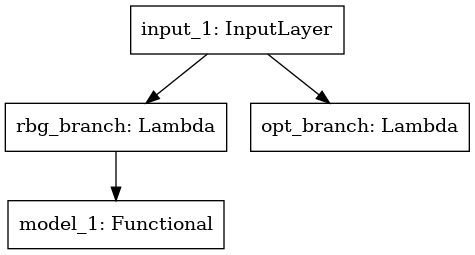

In [15]:
tf.keras.utils.plot_model(
   model
)

## Flow part

In [16]:
input_opt = model.get_layer('opt_branch').output
output_flow = flow_model(input_opt)
model  = Model(inputs=model.input, outputs=[output_flow, output_rgb])

In [17]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 224, 2 0                                            
__________________________________________________________________________________________________
opt_branch (Lambda)             (None, None, 224, 22 0           input_1[0][0]                    
__________________________________________________________________________________________________
rbg_branch (Lambda)             (None, None, 224, 22 0           input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 2)            12274640    opt_branch[0][0]                 
____________________________________________________________________________________________

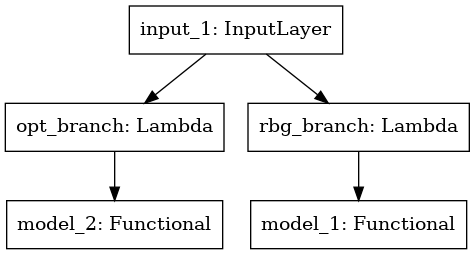

In [18]:
tf.keras.utils.plot_model(
   model
)

# Step 4: Adding fusion block

In [19]:
fusion = Add()(model.output)
fusion = Activation('softmax')(fusion)

In [20]:
model = Model(model.input, fusion)

In [21]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 224, 2 0                                            
__________________________________________________________________________________________________
opt_branch (Lambda)             (None, None, 224, 22 0           input_1[0][0]                    
__________________________________________________________________________________________________
rbg_branch (Lambda)             (None, None, 224, 22 0           input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 2)            12274640    opt_branch[0][0]                 
____________________________________________________________________________________________

# Step 5: Data generator

In [23]:
from fusioni3ddatagenerator import DataGenerator

In [24]:
# Parameters
batch_size = 8
path_train = '../datai3d/i3d_light/train/'
path_val = '../datai3d/i3d_light/validation/'
path_test = '../datai3d/i3d_light/test/'

In [25]:
# Create data generators for training, validation and test
train_generator = DataGenerator(directory=path_train,
                                batch_size=batch_size, 
                                shuffle=True,
                                data_augmentation=True,
                                target_frames = 79,
                                crop_dim = (224, 224),
                                flip = True)

validation_generator = DataGenerator(directory=path_val,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     data_augmentation=False,
                                     target_frames = None,
                                     crop_dim = (224, 224),
                                     flip = False)

test_generator = DataGenerator(directory=path_test,
                               batch_size=batch_size, 
                               shuffle = False,
                               data_augmentation=False,
                               target_frames = None,
                               crop_dim = (224, 224),
                               flip = False)

Found 1207 files belonging to 2 classes.
     Fight :  0
  NonFight :  1
Found 393 files belonging to 2 classes.
     Fight :  0
  NonFight :  1
Found 400 files belonging to 2 classes.
     Fight :  0
  NonFight :  1


# Step 6: Training

In [26]:
# Parameters
epochs = 100
steps_per_epoch = train_generator.n_files//batch_size
validation_steps = validation_generator.n_files//batch_size

# Path to store checkpoints
filepath = 'checkpoints/weights_fusioni3dfrozen.hdf5'

In [27]:
# Callbacks

# Reduce learning rate by 10x when plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.1,
                                                 patience=5, 
                                                 min_lr=0.0001,
                                                verbose = 1)

# Save best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                save_weights_only=False, 
                                                mode='auto', 
                                                save_freq='epoch')

# Stop after 10 epochs if val loss does not improve
earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             restore_best_weights = True, 
                                             patience = 10, 
                                             min_delta = 0.01,
                                            verbose = 1)

callbacks = [reduce_lr, checkpoint, earlystop]

In [28]:
# Create optimiser (SGD with momentum)
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)

# Compile model
model.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])

In [29]:
# Start training and save history
history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks = callbacks,
      verbose=1)

Epoch 1/100
150/150 [==============================] - 4752s 32s/step - loss: 0.4780 - accuracy: 0.7890 - val_loss: 0.4429 - val_accuracy: 0.7908

Epoch 00001: val_loss improved from inf to 0.44293, saving model to checkpoints/weights_fusioni3d.hdf5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
150/150 [==============================] - 4789s 32s/step - loss: 0.3436 - accuracy: 0.8424 - val_loss: 0.4501 - val_accuracy: 0.7985

Epoch 00002: val_loss did not improve from 0.44293
Epoch 3/100
150/150 [==============================] - 4565s 30s/step - loss: 0.3097 - accuracy: 0.8632 - val_loss: 0.4502 - val_accuracy: 0.8061

Epoch 00003: val_loss did not improve from 0.44293
Epoch 4/100
150/150 [==============================] - 4720s 32s/step - loss: 0.3067 - accuracy: 0.8632 - val_loss: 0.4480 - val_accuracy: 0.7908

Epoch 00004: val_loss did not improve from 0.44293
Epoch 5/100
150/150 [==============================] - 4719s 32s/step - loss: 0.2741 - accuracy: 0.8807 - val_loss: 0.4888 - val_accuracy: 0.7832

Epoch 00005: val_loss did not improve from 0.44293
Epoch 6/100
150/150 [==============================] - 4706s 31s/step - loss: 0.3169 - accuracy: 0.8641 - val_loss: 0.4757 - val_accuracy: 0.7959

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00

ResourceExhaustedError:  OOM when allocating tensor with shape[8,64,62,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_5/model_2/opt_MaxPool2d_2a_3x3/MaxPool3D (defined at <ipython-input-29-5393525774f5>:9) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_21909]

Function call stack:
test_function


In [30]:
# Save history of the model
import pickle
with open('history_i3dfusionfrozen', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

NameError: name 'history' is not defined

# Step 7: Evaluate on test set

In [ ]:
# Download our pretrained model
!mkdir checkpoints
%cd checkpoints
!gdown --id 16iTf2GwsEMufpa2F7ZYTxwdgwf7VXRW9
%cd ..

In [ ]:
model = tf.keras.models.load_model('checkpoints/weights_fusioni3dfrozen.hdf5')

In [35]:
test_steps = test_generator.n_files//batch_size

In [36]:
model.evaluate(test_generator,
               steps = test_steps,
               return_dict =  True)

50/50 [==============================] - 1213s 24s/step - loss: 0.2896 - accuracy: 0.8675


{'loss': 0.2895623743534088, 'accuracy': 0.8675000071525574}